# Submission Information:

## Kaggle Team Name: bermuda

### Team Member 1:
* UNI: ka2601
* Name: Keerti Agrawal

### Team Member 2 [optional]:
* UNI: jaj2186
* Name: Janak A Jain

# Step0 - Import Libraries, Load Data [0 points]

This is the basic step where you can load the data and create train and test sets for internal validation as per your convinience.

In [32]:
#write code below, you can make multiple cells
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import cross_validation, metrics   #Additional sklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 17, 5

In [2]:
#Loading Data
data = pd.read_csv("data.csv")
data= data.drop('duration', 1)

#Loading Holdout Set
holdout_data = pd.read_csv("holdout.csv")
holdout_data = holdout_data.drop(['duration'],1)

# Step1 - Exploration and Preparation [10 points]

In this step, we expect you to look into the data and try to understand it before modeling. This understanding may lead to some basic data preparation steps which are common across the two model sets required.

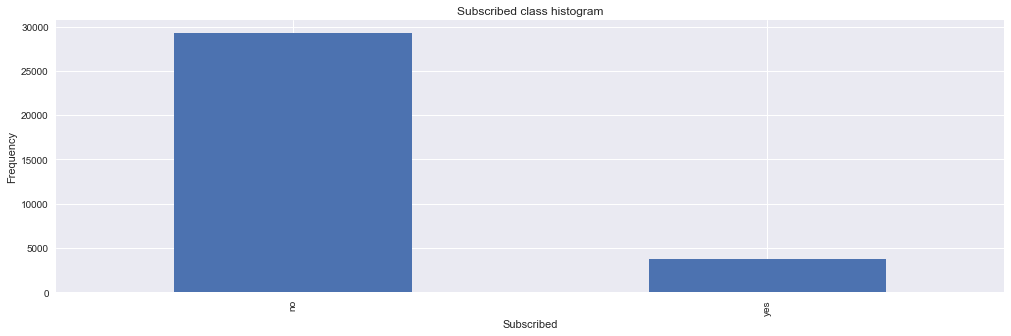

In [3]:
#write code below, you can make multiple cells

#Looking at the frequency of each class
count_classes = pd.value_counts(data['subscribed'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Subscribed class histogram")
plt.xlabel("Subscribed")
plt.ylabel("Frequency")
#Learning:
#Data seems to be imbalanced. Undersampling might be an option here. 

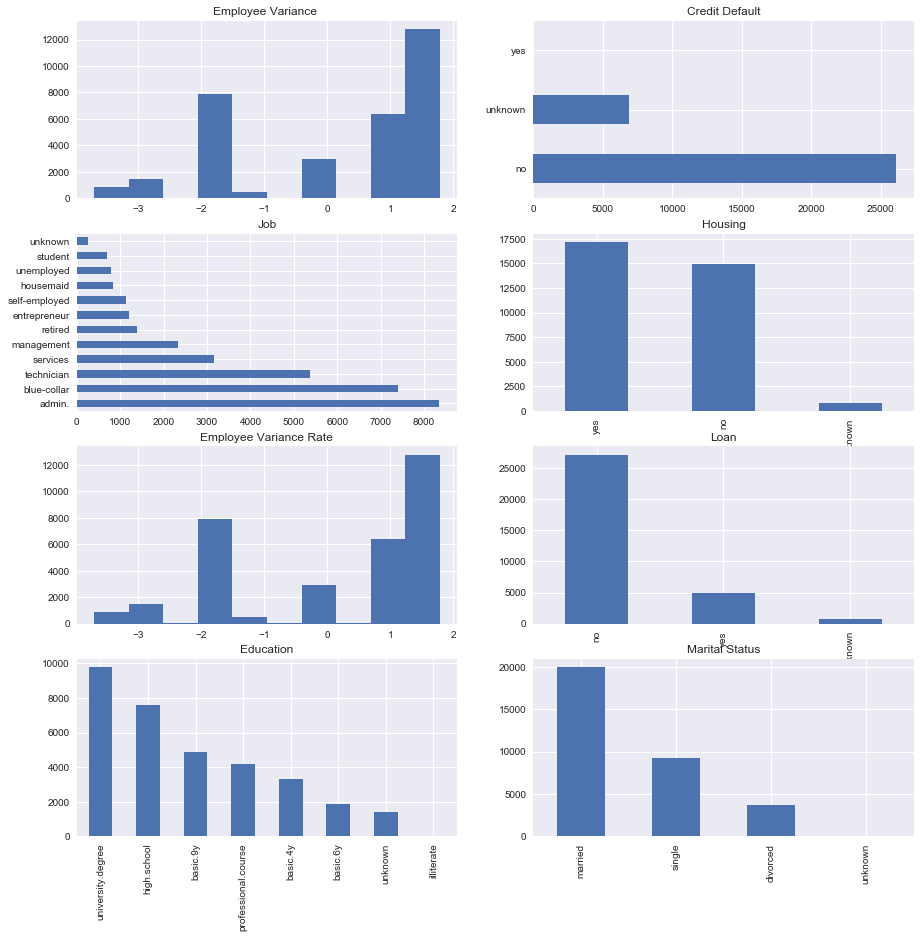

In [4]:
## Looking at the range of values for each categorical variable

rcParams['figure.figsize'] = 15, 15

plt.subplot(4,2,1)
plt.hist(data['emp_var_rate'])
plt.title("Employee Variance ")
plt.subplot(4,2,2)
data.credit_default.value_counts().plot(kind='barh')
plt.title("Credit Default")
plt.subplot(4,2,3)
data.job.value_counts().plot(kind='barh')
plt.title("Job")
plt.subplot(4,2,4)
data.housing.value_counts().plot(kind='bar')
plt.title("Housing")
plt.subplot(4,2,5)
plt.hist(data['emp_var_rate'])
plt.title("Employee Variance Rate")
plt.subplot(4,2,6)
data.loan.value_counts().plot(kind='bar')
plt.title("Loan")
plt.subplot(4,2,7)
data.education.value_counts().plot(kind='bar')
plt.title("Education")
plt.subplot(4,2,8)
data.marital_status.value_counts().plot(kind='bar')
plt.title("Marital Status")

#Learning:
# Job, Housing, Loan, Education, Marital Status have few unknown values which can be imputed by most frequent values.

In [7]:
#Imputation of Unknown Values by most frequent values of that feature:
data['marital_status']=data['marital_status'].replace(to_replace='unknown', value='married')
data['job']=data['job'].replace(to_replace='unknown', value='admin.')
data['loan']=data['loan'].replace(to_replace='unknown', value='no')
data['education']=data['education'].replace(to_replace='unknown', value='university.degree')
data['housing']=data['housing'].replace(to_replace='unknown', value='yes')

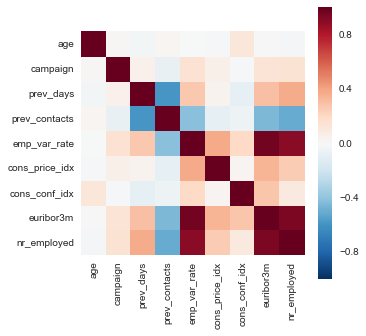

In [8]:
#Checking if there exists any correlation between continuous features
corr = data.corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr, vmax=1, square=True)

#Learning: All continuous features can be used in the models. 

# Step2 - ModelSet1 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set1:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. Any classification algorithm covered in class apart from tree-based models can be tested here.

In [9]:
## Splitting features into continuous and categorical variables

cate = ['job', 'education', 'loan', 'housing', 'marital_status', 'credit_default', 'contact', 'month', 
        'day_of_week', 'prev_outcomes']

conti = ['age', 'prev_days', 'prev_contacts', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 
         'euribor3m', 'nr_employed']

y = pd.DataFrame(data['subscribed'])

cate_data = data[cate]
conti_data = data[conti]

#holdout data
cate_hdata = holdout_data[cate]
conti_hdata = holdout_data[conti]

Feature Engineering:

In [10]:
## Converting Categorical variables to integer using get_dummies
df_with_dummies = pd.get_dummies(cate_data, columns = cate )
df_with_hdummies = pd.get_dummies(cate_hdata, columns = cate)

## Concatinating continuous and categorical variables:
final_df = pd.concat([conti_data, df_with_dummies], 1)
final_hdf = pd.concat([conti_hdata, df_with_hdummies], 1)

## No 'yes' values in holdout set for credit_default, adding one
final_hdf['credit_default_yes'] = 0

## Factorizing target variable to 0/1
y['subscribed'] = pd.factorize(y['subscribed'])[0]
train = pd.concat([final_df, y], 1)

target = 'subscribed'

# X_train, X_test, y_train, y_test = train_test_split(final_df, y, random_state=0,stratify=y)

In [11]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['subscribed'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    dholdout_predprob =  alg.predict_proba(final_hdf[predictors])[:,1]
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['subscribed'], 
                                                    cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['subscribed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['subscribed'], dtrain_predprob)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),
                                                                                 np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    
#     submit = pd.read_csv("sample_submission.csv")
#     submit['subscribed'] = dholdout_predprob
#     submit.to_csv("result_ensemble.csv", index=False)
    

## Gaussian NB

The Gaussian Naive Bayes classifier didn't give us very good results.

In [12]:
predictors = [x for x in train.columns if x not in [target]]
gnb = make_pipeline(StandardScaler(), GaussianNB())
modelfit(gnb, train, predictors, printFeatureImportance=False)


Model Report
Accuracy : 0.7337
AUC Score (Train): 0.771454
CV Score : Mean - 0.770099 | Std - 0.009766527 | Min - 0.7577338 | Max - 0.7830818


In [13]:
predictors = [x for x in train.columns if x not in [target]]

ada_class_gnb = AdaBoostClassifier(GaussianNB(),
                         algorithm="SAMME",n_estimators=200)
modelfit(ada_class_gnb, train, predictors, printFeatureImportance=False)


Model Report
Accuracy : 0.8793
AUC Score (Train): 0.779283
CV Score : Mean - 0.7211513 | Std - 0.02533604 | Min - 0.6968548 | Max - 0.7572582


## Logistic Regression

Logistic Regression gav us a better performance. However, we tuned the plain vanilla model to incorporate more robustness.

In [14]:
predictors = [x for x in train.columns if x not in [target]]
lr = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
modelfit(lr, train, predictors, printFeatureImportance=False)


Model Report
Accuracy : 0.8202
AUC Score (Train): 0.796813
CV Score : Mean - 0.7927649 | Std - 0.006331756 | Min - 0.78328 | Max - 0.8018893


#### Tuning Parameter C using GridSearchCV  
  
* Phase 1  
   * We first applied a **StandardScaler** to make the input more appropriate for the model. The StandardScaler standardizes the data and incorporates homogeneity of scale.
   * We then used **GrisSearchCV** to select the best parameters for the given model and data. These parameters were then used to produce the output.  
   * These two were put into a **pipeline** and run on the data to give results.  

* Phase 2  
  * In this phase, we tried how the scores improved after applying **PolynomialFeatures** transformation. However, we did not try the StandardScaler upon this because it was taking a lot of time.


### Phase 1: StandardScaler and GridSearchCV for Logistic Regression

In [15]:
predictors = [x for x in train.columns if x not in [target]]
param_grid = {"logisticregression__C": np.arange(0.5,1,0.1)}
lr = make_pipeline(StandardScaler(), LogisticRegression())
gsearch_lr = GridSearchCV(lr, param_grid=param_grid, cv=5)
gsearch_lr.fit(train[predictors], train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': array([ 0.5,  0.6,  0.7,  0.8,  0.9])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [16]:
gsearch_lr.best_params_

{'logisticregression__C': 0.59999999999999998}

#### Fitting model with tuned parameter value of C

In [17]:
predictors = [x for x in train.columns if x not in [target]]
lr_tuned = make_pipeline(StandardScaler(), LogisticRegression(C=0.59999999999999998, class_weight='balanced'))
modelfit(lr_tuned, train, predictors, printFeatureImportance=False)


Model Report
Accuracy : 0.8202
AUC Score (Train): 0.796815
CV Score : Mean - 0.7927663 | Std - 0.006328664 | Min - 0.7832775 | Max - 0.8018813


### Phase 2: Logistic Regression with Polynomial Features

In [18]:
predictors = [x for x in train.columns if x not in [target]]
pipe = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(class_weight='balanced'))
modelfit(pipe, train, predictors, printFeatureImportance=False)


Model Report
Accuracy : 0.8223
AUC Score (Train): 0.797374
CV Score : Mean - 0.792961 | Std - 0.006836737 | Min - 0.7825641 | Max - 0.802401


In [19]:
predictors = [x for x in train.columns if x not in [target]]
pipe = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(C=0.59999999999999998, class_weight='balanced'))
modelfit(pipe, train, predictors, printFeatureImportance=False)


Model Report
Accuracy : 0.8225
AUC Score (Train): 0.797388
CV Score : Mean - 0.7928379 | Std - 0.006690554 | Min - 0.7825459 | Max - 0.8022406


---  
## SVM  
  
We tried to run SVM. However, it was taking a lot of time, hence, sis not include this in the final selection of models. The model configuration is given below.

In [ ]:
# predictors = [x for x in train.columns if x not in [target]]

# svc = SVC(kernel='linear',
#           probability=True, 
#           gamma=.05, 
#           class_weight = 'balanced', 
#           cache_size=7000)

# modelfit(svc, train, predictors, printFeatureImportance=False)

---  
# Step3 - ModelSet2 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set2:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. We encourage you to try decition tree, random forest and gradient boosted tree methods here and pick the one which you think works best.

In [ ]:
#write code below, you can make multiple cells
# Looking for NaN
#train.isnull().any()

---  
### Decision Tree Classifier  
  
The Decision Tree calssifier gave us a good AUC score. However, it gave us a lower CV score.

In [29]:
predictors = [x for x in train.columns if x not in [target]]

dt_classifier = DecisionTreeClassifier(max_depth=10,
                                       criterion='gini',
                                       random_state=10)

modelfit(dt_classifier, train, predictors, printFeatureImportance=False)


Model Report
Accuracy : 0.9196
AUC Score (Train): 0.827709
CV Score : Mean - 0.715914 | Std - 0.01007541 | Min - 0.7072071 | Max - 0.7350081


**Tuning the decision tree**: We used GridSearchCV to fine-tune parameters of the DecisionTreeClassifier. The final model was saved in *dtc_tuned*.


Model Report
Accuracy : 0.7201
AUC Score (Train): 0.769796
CV Score : Mean - 0.7672463 | Std - 0.005534417 | Min - 0.7612782 | Max - 0.7757165


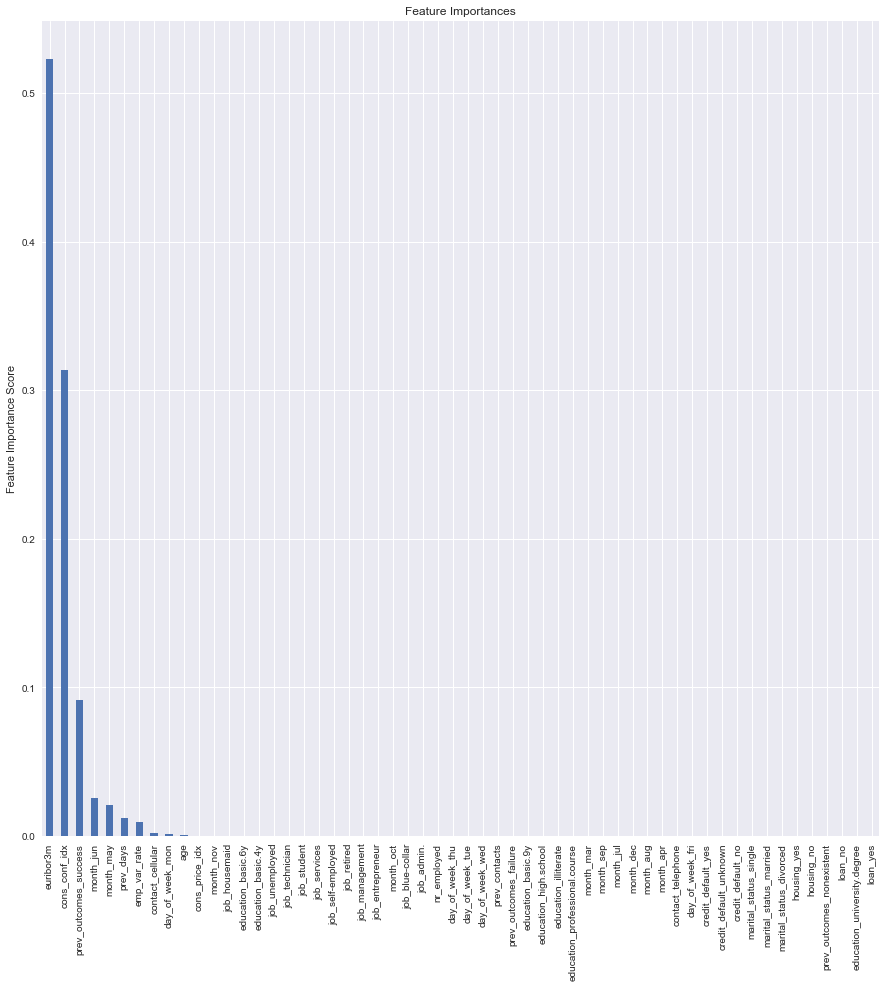

In [21]:
params = {"max_depth":range(1,5,1)}
gdecitree1 = GridSearchCV(estimator = DecisionTreeClassifier(random_state=10), 
                          param_grid = params, 
                          scoring='roc_auc',
                          cv=5)
gdecitree1.fit(train[predictors],train[target])
gdecitree1.best_params_

params = {"min_samples_split":range(2,500,10)}
gdecitree2 = GridSearchCV(estimator = DecisionTreeClassifier(random_state=10, 
                                                            max_depth = 4, 
                                                             max_features='sqrt'), 
                          param_grid = params, 
                          scoring='roc_auc',cv=5)
gdecitree2.fit(train[predictors],train[target])
gdecitree2.best_params_

params = {"min_samples_leaf":range(1,50,5)}
gdecitree3 = GridSearchCV(estimator = DecisionTreeClassifier(random_state=10, 
                                                             max_depth = 4, 
                                                             max_features='sqrt', 
                                                             min_samples_split=200), 
                          param_grid = params, 
                          scoring='roc_auc',cv=5)
gdecitree3.fit(train[predictors],train[target])
gdecitree3.best_params_

dtc_tuned = DecisionTreeClassifier(random_state=10, max_depth = 4, max_features='sqrt', 
                                                             min_samples_split=200, min_samples_leaf=46, 
                                                             class_weight='balanced')
modelfit(dtc_tuned, train, predictors)


---  
### Random Forest Classifier  
  
We initially applied **RandomForestClassifier** without any tuning and the model was overfitting to the extent that we recieved a score of 1.0. We then tuned the model to incorporate robustness and we finally got a very good score of 0.92. However, the cross validation score was still only marginally better at 0.7954.

In [ ]:
# Applying Random Forest Classifer without tuning:

# predictors = [x for x in train.columns if x not in [target]]
# rf_classifier = RandomForestClassifier(n_estimators=100)
# modelfit(rf_classifier, train, predictors, printFeatureImportance=False)

# This implementation gives up the following:

# Model Report
# Accuracy : 1
# AUC Score (Train): 1.000000
# CV Score : Mean - 0.777209 | Std - 0.004842604 | Min - 0.7704721 | Max - 0.7829121

In [22]:
# We have tweaked the Random Forest Classifier model to accomodate randomness and robustness.

predictors = [x for x in train.columns if x not in [target]]

rf_classifier = RandomForestClassifier(n_estimators=100,
                                       criterion='gini', # 'entropy' didn't perform better than 'gini'
                                       max_depth=12,
                                       random_state=42,
                                       max_features=10)

modelfit(rf_classifier, train, predictors, printFeatureImportance=False)


Model Report
Accuracy : 0.929
AUC Score (Train): 0.920394
CV Score : Mean - 0.795438 | Std - 0.004375152 | Min - 0.7911382 | Max - 0.8032214


### Gradient Boosting Tree

In [23]:
predictors = [x for x in train.columns if x not in [target]]
gb_classifier = GradientBoostingClassifier(n_estimators=100,learning_rate=0.01)
modelfit(gb_classifier, train, predictors, printFeatureImportance=False)


Model Report
Accuracy : 0.8969
AUC Score (Train): 0.778520
CV Score : Mean - 0.7788653 | Std - 0.008099522 | Min - 0.76911 | Max - 0.7881963


---  
### XGBoost   
  
We used the XGBoost algorithm which was tuned several times till it seemed robust. However, since XGBoost is not a part of the _sklearn_ package, it doesn't have a get_params method which could be used for our final ensemble. Hence, this model was not included in the final list of classifiers.

In [24]:
features = np.setdiff1d(train.columns, ['subscribed', 'duration'])

params = {"objective": "binary:logistic", 
          "booster": "dart", "nthread": 4, 
          "silent": 1,
          "eta": 0.15, 
          "max_depth": 4, 
          "subsample": 0.95, 
          "colsample_bytree": 0.9,
          "min_child_weight": 10, 
          "eval_metric": "auc",
          "seed": 2017, 
          "tree_method": 'auto',
          "sample_type":"weighted"}

dtrain = xgb.DMatrix(train[features], train['subscribed'], missing=np.nan)
dtest = xgb.DMatrix(train[features], missing=np.nan)

xgb_classifier = xgb.cv(params, dtrain, nfold=10, num_boost_round=10000, early_stopping_rounds=10, verbose_eval=True)

[0]	train-auc:0.759461+0.00588369	test-auc:0.756692+0.0126389
[1]	train-auc:0.778983+0.0134182	test-auc:0.774339+0.0156335
[2]	train-auc:0.789847+0.00400874	test-auc:0.784473+0.0119627
[3]	train-auc:0.792997+0.00257203	test-auc:0.788788+0.014768
[4]	train-auc:0.793989+0.00246195	test-auc:0.789189+0.0139121
[5]	train-auc:0.794885+0.00189725	test-auc:0.79059+0.0144517
[6]	train-auc:0.795325+0.00194319	test-auc:0.790511+0.0144934
[7]	train-auc:0.796237+0.00192644	test-auc:0.790884+0.0141681
[8]	train-auc:0.79692+0.00194445	test-auc:0.791089+0.0146825
[9]	train-auc:0.797654+0.00181752	test-auc:0.79212+0.0141969
[10]	train-auc:0.798428+0.00196189	test-auc:0.793002+0.0139774
[11]	train-auc:0.799687+0.00212963	test-auc:0.792707+0.0130809
[12]	train-auc:0.800843+0.00217571	test-auc:0.793437+0.0130525
[13]	train-auc:0.80213+0.00222421	test-auc:0.79423+0.0132075
[14]	train-auc:0.802978+0.00208259	test-auc:0.794752+0.0134657
[15]	train-auc:0.804061+0.00201199	test-auc:0.795132+0.0132584
[16]	trai

---  
# Step4 - Ensemble [20 points + 10 Bonus points]

In this step, we expect you to use the models created before and create new predictions. You should definitely try poor man's stacking but we encourage you to think of different ensemble techniques as well. We will judge your creativity and improvement in model performance using ensemble models and you can potentially earn 10 bonus points here.

In [25]:
voting_classifier = VotingClassifier(estimators=[('Gaussian_NB (Adaboosted)', ada_class_gnb), 
                                                 ('Logistic Regression', lr_tuned), 
                                                 ('Logistic Regression with Polynomial Features', pipe),
                                                 ('Decision Tree Classifier (Tuned)',dtc_tuned),
                                                 ('Random Forest Classifier',rf_classifier),
                                                 ('Gradient Boosting Tree Classifier',gb_classifier)], 
                                     voting='soft')

In [26]:
predictors = [x for x in train.columns if x not in [target]]
modelfit(voting_classifier, train, predictors, printFeatureImportance=False)


Model Report
Accuracy : 0.8806
AUC Score (Train): 0.819200
CV Score : Mean - 0.7948178 | Std - 0.006428596 | Min - 0.7857184 | Max - 0.8045287


### Hands-on undersampling

In [33]:
def under_sampling(estimator, n_estimators=100):
    estimators=[]
    for i in range(n_estimators):
        est = clone(estimator)
        if hasattr(est, "random_state"):
            est.random_state=i
        pipe = make_imb_pipeline(RandomUnderSampler(random_state=i, replacement = True), est)
        estimators.append(("est_i".format(i), pipe))
    return VotingClassifier(estimators, voting = "soft")



resampled_tree_test = under_sampling(DecisionTreeClassifier(max_features='auto'))
scores = cross_val_score(resampled_tree_test, train[predictors], train[target], cv=5, scoring='roc_auc')
print(np.mean(scores))

0.78578062239


In [ ]:
#write code below, you can make multiple cells
assert True